# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
import itertools
from sklearn.linear_model import LogisticRegression

In [0]:
PATH_TO_DATA = Path('')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [0]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        try:
          ind = self.word2id[word]
          return self.embeddings[ind]
        except KeyError: 
          return [0] * len(self.embeddings[0])
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        emb1, emb2 = self.encode(word1), self.encode(word2)
        return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        similarities = [self.score(word, curr_word) for curr_word in self.words]
        ind = np.argsort(similarities)[::-1][:k+1]
        similar_words = [self.id2word[i] for i in ind]
        similar_words.remove(word)
        return similar_words

In [12]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf = {}
        all_words = np.array([sentence.split() for sentence in sentences])
        all_words = list(itertools.chain.from_iterable(all_words))
        for word in all_words:
          try:
            idf[word] += 1
          except KeyError:
            idf[word] = 1
        N = len(all_words)
        for word in idf.keys():
            idf[word] = max(np.log10(N / idf[word]), 1)
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            # mean of word vectors
            return np.mean( [self.word2vec.encode(word) for word in sentence.split()], axis=0 )
        else:
            # idf-weighted mean of word vectors
            emb_size = len(self.word2vec.embeddings[0])
            return np.mean( [np.multiply(idf[word], self.word2vec.encode(word)) if word in idf.keys() 
                             else [0] * emb_size
                             for word in sentence.split()], axis=0 )

    def cosine_similarity(self, emb1, emb2):
        return np.dot(emb1, emb2) / ( np.linalg.norm(emb1) * np.linalg.norm(emb2) )
    
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        emb1, emb2 = self.encode(sentence1, idf), self.encode(sentence2, idf)
        return self.cosine_similarity(emb1, emb2)
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = [self.encode(sentence, idf) for sentence in sentences]
        similarities = [self.cosine_similarity(query, key) for key in keys]
        ind = np.argsort(similarities)[::-1][:k+1]
        similar_sent = [sentences[i] for i in ind]
        similar_sent.remove(sentence)
        return similar_sent

In [14]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6802446406269929
a young boy and 2 girls open christmas presents . 
1) 3 girls and one boy playing in the street . 
2) 2 older women and a young girl with a red bike . 
3) a little boy and 4 turkeys walking 
4) five children , 3 boys and 2 girls playing soccer in a grass field . 
5) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **$W^* = argmin || W.X - Y ||$  s.t $W^T.W = Id$**
has a closed form solution:
**$W = U.V^T$  where $U.Sig.V^T = SVD(Y.X^T)$**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        common_words = list(np.intersect1d( fr_word2vec.words, en_word2vec.words ))
        XY = [ [fr_word2vec.encode(word), en_word2vec.encode(word)] for word in common_words ]
        X, Y = zip(*XY)
        X, Y = np.vstack(X).T, np.vstack(Y).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, Vt = np.linalg.svd( np.dot(Y, X.T) )
        W = np.dot( U, Vt )
        assert W.shape == (300, 300)
        return np.dot(fr_word2vec.embeddings, W.T)

    def cosine_similarity(self, emb1, emb2):
        return np.dot(emb1, emb2) / ( np.linalg.norm(emb1) * np.linalg.norm(emb2) )
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        fr_word_ind = self.fr_word2vec.word2id[fr_word]
        fr_en_word_emb = self.aligned_fr_embeddings[fr_word_ind]
        similarities = [self.cosine_similarity(fr_en_word_emb, en_emb) for en_emb in self.en_word2vec.embeddings]
        ind = np.argsort(similarities)[::-1][:k+1]
        similar_words = [self.en_word2vec.id2word[i] for i in ind]
        return similar_words

In [16]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
en: "pet"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
en: "pup"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
en: "motorbike"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"
en: "nope"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [17]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

def read_to_sentences(filepath, w2v, isY=False):
  sentences = []
  y = []
  with open(filepath, 'r') as f:
      lines = [line.strip('\n') for line in f]
      for line in lines:
        line_split = line.split(" ")
        if isY:
          y.append(line_split[0])
          sentence = [word for word in line_split[1:] if word in w2v.words]
          sentences.append(" ".join(sentence))
        else:
          sentence = [word for word in line_split if word in w2v.words]
          sentences.append(" ".join(sentence))
  return sentences, y

train_sentences, train_y = read_to_sentences(train_filepath, word2vec, True)
dev_sentences, dev_y = read_to_sentences(dev_filepath, word2vec, True)
test_sentences, _ = read_to_sentences(test_filepath, word2vec, False)

Loaded 50000 pretrained word vectors


In [0]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
train_bov = []
train_idf_bov = []
train_idf = sentence2vec.build_idf(train_sentences)
for sentence in train_sentences:
    train_bov.append(sentence2vec.encode(sentence))
    train_idf_bov.append(sentence2vec.encode(sentence, train_idf))    

dev_bov = []
dev_idf_bov = []
dev_idf = sentence2vec.build_idf(dev_sentences)
for sentence in dev_sentences:
    dev_bov.append(sentence2vec.encode(sentence))
    dev_idf_bov.append(sentence2vec.encode(sentence, dev_idf))  

test_bov = []
test_idf_bov = []
test_idf = sentence2vec.build_idf(test_sentences)
for sentence in test_sentences:
    test_bov.append(sentence2vec.encode(sentence))
    test_idf_bov.append(sentence2vec.encode(sentence, test_idf))  

In [0]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
logreg_clf = LogisticRegression(penalty="l2", max_iter=500, C=1)
logreg_clf.fit(train_bov, train_y)
print("Accuracy on the training set (average): ", logreg_clf.score(train_bov, train_y))
print("Accuracy on the validation set (average): ", logreg_clf.score(dev_bov, dev_y))

logreg_clf_idf = LogisticRegression(penalty="l2", max_iter=500, C=0.7)
logreg_clf_idf.fit(train_idf_bov, train_y)
print("Accuracy on the training set (weighted-average): ", logreg_clf_idf.score(train_idf_bov, train_y))
print("Accuracy on the validation set (weighted-average): ", logreg_clf_idf.score(dev_idf_bov, dev_y))

Accuracy on the training set (average):  0.4288389513108614
Accuracy on the validation set (average):  0.3905540417801998
Accuracy on the training set (weighted-average):  0.46886704119850187
Accuracy on the validation set (weighted-average):  0.42779291553133514


In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
logreg_clf_idf = LogisticRegression(penalty="l2", max_iter=500, C=0.7)
logreg_clf_idf.fit(train_idf_bov + dev_idf_bov, train_y + dev_y)
test_y_pred = logreg_clf_idf.predict(test_idf_bov)
np.savetxt("logreg_bov_y_test_sst.txt", test_y_pred.astype(int), fmt='%i', delimiter="\n")

In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.neural_network import MLPClassifier
NN_clf = MLPClassifier(hidden_layer_sizes=(30, 10), alpha=0.001, batch_size=32, 
                   validation_fraction = 0.1, early_stopping = True, verbose = False, 
                   random_state = 777, learning_rate='adaptive', max_iter=150, 
                   learning_rate_init=0.0005, activation="relu", solver="adam")
NN_clf.fit(train_bov, train_y)
print("Accuracy on the training set (average): ", NN_clf.score(train_bov, train_y))
print("Accuracy on the validation set (average): ", NN_clf.score(dev_bov, dev_y))

NN_clf_idf = MLPClassifier(hidden_layer_sizes=(30, 10), alpha=0.001, batch_size=32, 
                   validation_fraction = 0.1, early_stopping = True, verbose = False, 
                   random_state = 777, learning_rate='adaptive', max_iter=150, 
                   learning_rate_init=0.0005, activation="relu", solver="adam")
NN_clf_idf.fit(train_idf_bov, train_y)
print("Accuracy on the training set (weighted-average): ", NN_clf_idf.score(train_idf_bov, train_y))
print("Accuracy on the validation set (weighted-average): ", NN_clf_idf.score(dev_idf_bov, dev_y))

NN_clf_idf.fit(train_idf_bov + dev_idf_bov, train_y + dev_y)
test_y_pred = NN_clf_idf.predict(test_idf_bov)
np.savetxt("mlpclassifier_bov_y_test_sst.txt", test_y_pred.astype(int), fmt='%i', delimiter="\n")

Accuracy on the training set (average):  0.46348314606741575
Accuracy on the validation set (average):  0.4114441416893733
Accuracy on the training set (weighted-average):  0.47787921348314605
Accuracy on the validation set (weighted-average):  0.4150772025431426


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers
from keras.utils.np_utils import to_categorical
from tensorflow.keras.initializers import Constant
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
N_vocab = 50000
train_onehot = []
for sentence in train_sentences:
  train_onehot.append(one_hot(sentence, N_vocab))

dev_onehot = []
for sentence in dev_sentences:
  dev_onehot.append(one_hot(sentence, N_vocab))

test_onehot = []
for sentence in test_sentences:
  test_onehot.append(one_hot(sentence, N_vocab))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
max_len = min(500,max([len(sentence) for sentence in train_sentences + dev_sentences + test_sentences]) )

train_dl = pad_sequences(train_onehot, maxlen=max_len)
dev_dl   = pad_sequences(dev_onehot, maxlen=max_len)
test_dl  = pad_sequences(test_onehot, maxlen=max_len)

## 4.2 - Design and train your model

In [0]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.

# ADAPT CODE BELOW
clear_session()

embed_dim  = 300  # word embedding dimension
nhid       = 500  # number of hidden units in the LSTM
vocab_size = N_vocab  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.3, activation="relu", kernel_regularizer="l2", recurrent_regularizer="l2"))
model.add(Dense(n_classes, activation='softmax'))

In [27]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
mc = ModelCheckpoint("best_model", monitor='val_loss', verbose=0, save_best_only=True)
ls = LearningRateScheduler(lambda x: 0.0001 + 0.0001/(x+1)**2)
es = EarlyStopping(monitor='val_loss', patience=7)
cb = [es, mc, ls]

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizers.Adam(lr=0.0001) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 500)               1602000   
_________________________________________________________________
dense (Dense)                (None, 5)                 2505      
Total params: 16,604,505
Trainable params: 16,604,505
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 111s 13ms/sample - loss: 4.3395 - acc: 0.2700 - val_loss: 1.8099 - val_acc: 0.2534
Epoch 2/5
8544/8544 [==============================] - 111s 13ms/sample - loss: 1.6528 - acc: 0.2725 - val_loss: 1.5909 - val_acc: 0.2534
Epoch 3/5
8544/8544 [==============================] - 109s 13ms/sample - loss: 1.5723 - acc: 0.2949 - val_loss: 1.5756 - val_acc: 0.2570
Epoch 4/5
8544/8544 [==============================] - 110s 13ms/sample - loss: 1.5606 - acc: 0.3207 - val_loss: 1.5748 - val_acc: 0.2770
Epoch 5/5
8544/8544 [==============================] - 110s 13ms/sample - loss: 1.5390 - acc: 0.3599 - val_loss: 1.5452 - val_acc: 0.3588


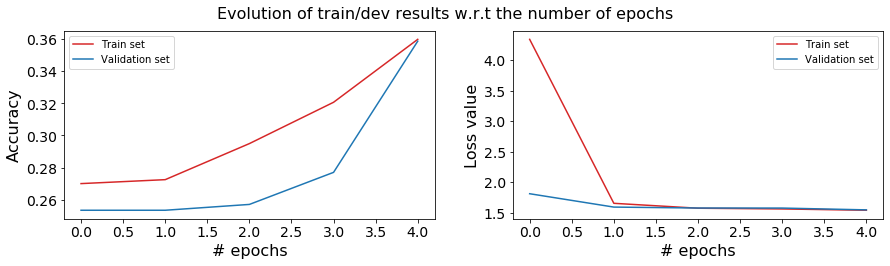

In [28]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

# ADAPT CODE BELOW
bs = 32
n_epochs = 5

# shuffle data
indices = np.arange(train_dl.shape[0])
np.random.shuffle(indices)
train_dl = train_dl[indices]

# transform labels to categorical
train_y_dl = to_categorical(train_y, num_classes=n_classes)
train_y_dl = train_y_dl[indices]
dev_y_dl   = to_categorical(dev_y, num_classes=n_classes)

# fit model
history = model.fit(train_dl, train_y_dl, batch_size=bs, epochs=n_epochs, 
                    validation_data=(dev_dl, dev_y_dl), callbacks=cb)

#####################################################
# define function to plot results evolution
def plot_acc_loss(history, n_epochs):
    epochs = range(n_epochs)
    fig = plt.figure(figsize=(13,4))
    fig.suptitle('Evolution of train/dev results w.r.t the number of epochs', fontsize=16)
    colors = ['tab:red', 'tab:blue']

    plt.subplot(1,2,1)
    plt.xlabel('# epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot(epochs, history.history['acc'], color=colors[0], label="Train set")
    plt.plot(epochs, history.history['val_acc'], color=colors[1], label="Validation set")
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('# epochs', fontsize=16)
    plt.ylabel('Loss value', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.plot(epochs, history.history['loss'], color=colors[0], label="Train set")
    plt.plot(epochs, history.history['val_loss'], color=colors[1], label="Validation set")
    plt.legend()

    fig.tight_layout(pad=3)

plot_acc_loss(history, len(history.history['loss']))

In [0]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
test_y_pred = model.predict_classes(test_dl)
np.savetxt("logreg_lstm_y_test_sst.txt", test_y_pred.astype(int), fmt='%i', delimiter="\n")

## 4.3 - innovate !

Found 11226 unique tokens.
Shape of data tensor: (9645, 251)
Shape of label tensor: (9645, 5)
Preparing embedding matrix.
Training model.
Train on 8544 samples, validate on 1101 samples
Epoch 1/100
8544/8544 [==============================] - 230s 27ms/sample - loss: 8.8680 - acc: 0.2283 - weighted_acc: 0.2394 - val_loss: 1.7150 - val_acc: 0.2561 - val_weighted_acc: 0.2561
Epoch 2/100
8544/8544 [==============================] - 234s 27ms/sample - loss: 7.2347 - acc: 0.3296 - weighted_acc: 0.3676 - val_loss: 1.7032 - val_acc: 0.3315 - val_weighted_acc: 0.3315
Epoch 3/100
8544/8544 [==============================] - 232s 27ms/sample - loss: 6.1558 - acc: 0.4586 - weighted_acc: 0.4952 - val_loss: 1.7258 - val_acc: 0.3551 - val_weighted_acc: 0.3551
Epoch 4/100
8544/8544 [==============================] - 227s 27ms/sample - loss: 5.1785 - acc: 0.5823 - weighted_acc: 0.6113 - val_loss: 1.8811 - val_acc: 0.3569 - val_weighted_acc: 0.3569
Epoch 5/100
8544/8544 [==============================]

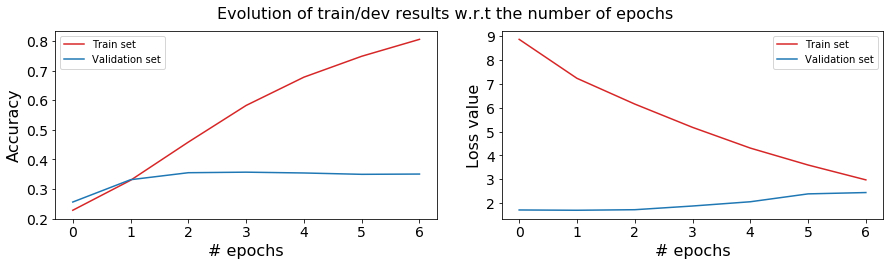

In [35]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

MAX_SEQUENCE_LENGTH = max_len
MAX_NUM_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

# define class weights (as we deal with unbalanced dataset)
_, cnts = np.unique(train_y, return_counts=True)
class_weights = {}
for i in range(n_classes):
    class_weights[i] = len(train_y) / cnts[i]

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
texts = train_sentences + dev_sentences
labels = train_y + dev_y
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
tokenizer.fit_on_texts(test_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# shuffle and split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = len(dev_sentences)

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    try :
      embedding_vector = word2vec.embeddings[word2vec.word2id[word]]
    except KeyError:
      embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
print('Training model.')

# train model
clear_session()
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(250, dropout=0.5, kernel_regularizer="l2")))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'], weighted_metrics=["acc"])

es = EarlyStopping(monitor='val_weighted_acc', patience=3)
cb = [es]

history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          validation_data=(x_val, y_val),
          callbacks=cb, class_weight=class_weights)

plot_acc_loss(history, len(history.history['loss']))

In [38]:
model.fit(np.concatenate([x_train, x_val]), np.concatenate([y_train, y_val]), 
          batch_size=32, nb_epoch=4, validation_split=0.2,
          callbacks=cb, class_weight=class_weights)
test_y_pred = model.predict_classes(x_test)
np.savetxt("nn_bilstm_y_test_sst.txt", test_y_pred.astype(int), fmt='%i', delimiter="\n")

Train on 7716 samples, validate on 1929 samples
Epoch 1/4
7716/7716 [==============================] - 213s 28ms/sample - loss: 2.9118 - acc: 0.8196 - weighted_acc: 0.8348 - val_loss: 1.7922 - val_acc: 0.5697 - val_weighted_acc: 0.5697
Epoch 2/4
7716/7716 [==============================] - 217s 28ms/sample - loss: 2.1889 - acc: 0.8696 - weighted_acc: 0.8796 - val_loss: 1.9271 - val_acc: 0.5469 - val_weighted_acc: 0.5469
Epoch 3/4
7716/7716 [==============================] - 208s 27ms/sample - loss: 1.8464 - acc: 0.8946 - weighted_acc: 0.9028 - val_loss: 2.0664 - val_acc: 0.5251 - val_weighted_acc: 0.5251
Epoch 4/4
7716/7716 [==============================] - 208s 27ms/sample - loss: 1.6045 - acc: 0.9126 - weighted_acc: 0.9202 - val_loss: 2.1281 - val_acc: 0.5143 - val_weighted_acc: 0.5143
